Quantum generative model on quantum data set in one cluster

In [2]:
import numpy as np
import tensorcircuit as tc
from scipy.stats import unitary_group
import tensorflow as tf
from opt_einsum import contract
from QDDPM_tf import OneQubitDiffusionModel, MultiQubitDiffusionModel
from QDDPM_tf import QDDPM
from QDDPM_tf import naturalDistance, WassDistance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
rc('text', usetex=True)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module
c:\Users\Bingzhi\envs\tensorCircuit_tf\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## data set generation

In [15]:
def cluster0Gen(n, N_train, scale, seed=None):
    # generate random quantum states close to |0...0>
    np.random.seed(seed)
    remains = np.random.randn(N_train,2**n-1)+1j*np.random.randn(N_train,2**n-1)
    states = np.hstack((np.ones((N_train,1)), scale*remains))
    states /= np.tile(np.linalg.norm(states, axis=1).reshape((1, N_train)), (2**n, 1)).T
    return states.astype(np.complex64)

# 1-qubit cluster problem

## Generate diffusion data

In [ ]:
# generate dfifusion data set
n = 1
T = 20
N = 1000

with tf.device('cpu'):
    diff_hs = np.linspace(1., 4., T)
    diff_hs = tf.convert_to_tensor(diff_hs)

    model_diff = OneQubitDiffusionModel(T, N)
    X = tf.convert_to_tensor(cluster0Gen(1, 1000, 0.08, seed=12))
    Xout = np.zeros((T+1, N, 2**n), dtype=np.complex64)
    Xout[0] = X
    for t in range(1, T+1):
        Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed=t).numpy()
np.save('data/QDDPM/cluster0/n1/cluster0Diff_n1T20_N%d.npy'%N, Xout)

In [25]:
np.mean(np.abs(Xout[:,:,0])**2, axis=1)

array([0.9875708 , 0.97546417, 0.9599374 , 0.9348827 , 0.913187  ,
       0.8882411 , 0.8588875 , 0.8205397 , 0.78961545, 0.754197  ,
       0.7056669 , 0.6778008 , 0.6525499 , 0.61731035, 0.58446205,
       0.5639962 , 0.54334086, 0.5265438 , 0.5455722 , 0.51457006,
       0.4878608 ], dtype=float32)

visulaize the decay of fidelity

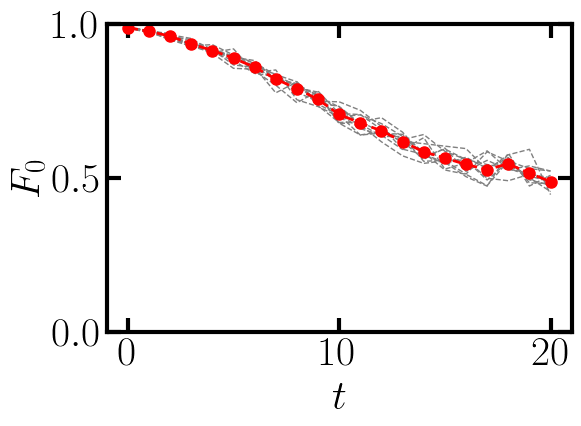

In [2]:
# visualize the fidelity decay in the diffusion process
n = 1
T = 20
N = 1000
states_diff = np.load('data/QDDPM/cluster0/n%d/cluster0Diff_n%dT%d_N%d.npy'%(n, n, T, N))
fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(1000)
for i in range(10):
    ax.plot(range(T+1), np.mean(np.abs(states_diff[:, indices[100*i:100*(i+1)], 0])**2, axis=1),
            '--', lw=1, c='grey')
ax.plot(range(T+1), np.mean(np.abs(states_diff[:,:,0])**2, axis=1), 'o--', markersize=8, lw=2, c='r')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
plt.show()
plt.close()

## Compare the performance of MMD and Wasserstein distance

In [33]:
# compare with different distance measure
X = tf.convert_to_tensor(np.load('data/QDDPM/cluster0/n1/cluster0Diff_n1T20_N1000.npy'))
X0 = tf.convert_to_tensor(cluster0Gen(1, 100, 0.08, seed=16))
XT = tf.cast(tf.convert_to_tensor(unitary_group.rvs(2, size=100)[:,:, 0]), dtype=tf.complex64)

nd = np.zeros((2, T+1))
wd = np.zeros((2, T+1))
for t in range(T+1):
    np.random.seed()
    idx = np.random.choice(1000, 100, replace=False)
    nd[0, t] = naturalDistance(X0, X[t, idx])
    wd[0, t] = WassDistance(X0, X[t, idx])
    nd[1, t] = naturalDistance(XT, X[t, idx])
    wd[1, t] = WassDistance(XT, X[t, idx])
np.save('data/QDDPM/cluster0/n1/cluster0Diffnat_n1T20_N100.npy', nd)
np.save('data/QDDPM/cluster0/n1/cluster0Diffwd_n1T20_N100.npy', wd)

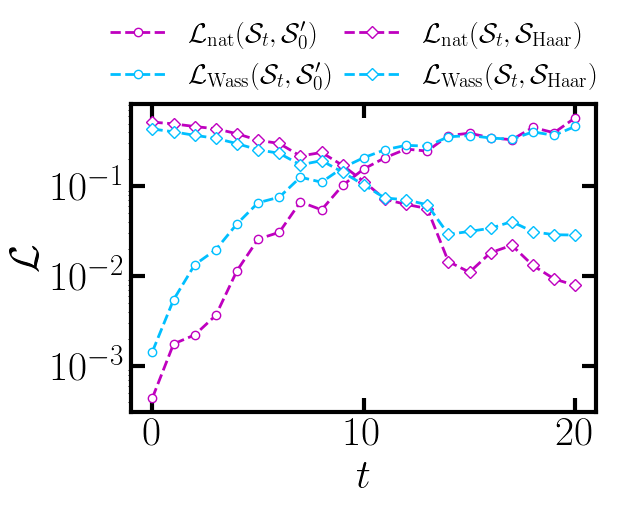

In [34]:
# plot different distance measures
nd = np.load('data/QDDPM/cluster0/n1/cluster0Diffnat_n1T20_N100.npy')
wd = np.load('data/QDDPM/cluster0/n1/cluster0Diffwd_n1T20_N100.npy')

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(nd[0], 'o--', mfc='white', markersize=6, lw=2, c='m', 
        label=r'$\mathcal{L}_{\rm nat}(\mathcal{S}_t,\mathcal{S}^\prime_0)$')
ax.plot(wd[0], 'o--', mfc='white', markersize=6, lw=2, c='deepskyblue', 
        label=r'$\mathcal{L}_{\rm Wass}(\mathcal{S}_t,\mathcal{S}^\prime_0)$')
ax.plot(nd[1], 'D--', mfc='white', markersize=6, lw=2, c='m', 
        label=r'$\mathcal{L}_{\rm nat}(\mathcal{S}_t,\mathcal{S}_{\rm Haar})$')
ax.plot(wd[1], 'D--', mfc='white', markersize=6, lw=2, c='deepskyblue', 
        label=r'$\mathcal{L}_{\rm Wass}(\mathcal{S}_t,\mathcal{S}_{\rm Haar})$')
ax.legend(fontsize=20, framealpha=0, ncol=2, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.35))
ax.set_yscale('log')
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{L}$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
plt.show()
plt.close()

In [ ]:
def clusterTraining_t(model, t, inputs_T, params_tot, Ndata, epochs, dis_measure='nat'):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    dis_measure: the distance measure to compare two distributions of quantum states
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history
    f0_hist = [] # record of fidelity history

    # initialize parameters
    tf.random.set_seed(None)
    params_t = tf.Variable(tf.random.normal([2 * model.n_tot * model.L]))
    # set optimizer and learning rate decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        0.01, 400, 0.5, staircase=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]
        with tf.GradientTape() as tape:
            output_t = model.backwardOutput_t(input_tplus1, params_t)
            if dis_measure == 'nat':
                # natural distance
                loss = naturalDistance(output_t, true_data)
            elif dis_measure == 'wd':
                # Wassastein distance
                loss = WassDistance(output_t, true_data)
        grads = tape.gradient(loss, [params_t])
        optimizer.apply_gradients(zip(grads, [params_t]))

        loss_hist.append(tf.stop_gradient(loss)) # record the current loss
        f0_hist.append(tf.math.reduce_mean(tf.abs(tf.stop_gradeint(output_t)[:, 0])**2))

    return tf.stop_gradient(params_t), tf.squeeze(tf.stack(loss_hist)), tf.squeeze(tf.stack(f0_hist))

In [3]:
# denoise training
n, na = 1, 1
T = 20
L = 4
Ndata = 100
epochs = 1000
method = 'nat'

with tf.device('cpu'):
    diffModel = MultiQubitDiffusionModel(n, T, Ndata)
    inputs_T = diffModel.HaarSampleGeneration(Ndata, seed=22)
    
    states_diff = np.load('data/QDDPM/cluster0/n1/cluster0Diff_n1T20_N1000.npy')
    model = QDDPM(n=n, na=na, T=T, L=L)
    model.set_diffusionSet(states_diff)

    for t in range(T-1, -1, -1):
        params_tot = np.zeros((T, 2*(n+na)*L))
        for tt in range(t+1, 20):
            params_tot[tt] = np.load('data/QDDPM/cluster0/n1/record/QDDPMcluster0params_n1na1T20L6_t%d_%s.npy'
                                    %(tt, method))
        params, loss, f0 = clusterTraining_t(model, t, params_tot, Ndata, epochs, method)

## Generate backward training and testing data set

In [9]:
# collect trainining result
n, na = 1, 1
T = 20
L = 4
Ndata = 100
epochs = 1000
method = 'nat'

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))
f0_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('data/QDDPM/cluster0/n%d/record/QDDPMcluster0params_n%dna%dT%dL%d_t%d_%s.npy'
                            %(n, n, na, T, L, t, method))
    loss_tot[t] = np.load('data/QDDPM/cluster0/n%d/record/QDDPMcluster0loss_n%dna%dT%dL%d_t%d_%s.npy'
                            %(n, n, na, T, L, t, method))
    f0_tot[t] = np.load('data/QDDPM/cluster0/n%d/record/QDDPMcluster0f0_n%dna%dT%dL%d_t%d_%s.npy'
                            %(n, n, na, T, L, t, method))
np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0params_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method), params_tot)
np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0loss_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method), loss_tot)
np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0f0_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method), f0_tot)

In [52]:
# generate training & test data
n, na = 1, 1
T = 20
L = 4
Ndata = 100
method = 'nat'

diffModel = MultiQubitDiffusionModel(n, T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22)
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=28)

params_tot = np.load('data/QDDPM/cluster0/n%d/QDDPMcluster0params_n%dna%dT%dL%d_%s.npy'
                     %(n, n, na, T, L, method))

with tf.device('cpu'):
    model = QDDPM(n=n, na=na, T=T, L=L)

    dataset_train = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n].numpy()
    dataset_test = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n].numpy()
    np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0trainGen_n%dna%dT%dL%d_%s.npy'
            %(n, n, na, T, L, method), dataset_train)
    np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0testGen_n%dna%dT%dL%d_%s.npy'
            %(n, n, na, T, L, method), dataset_test)

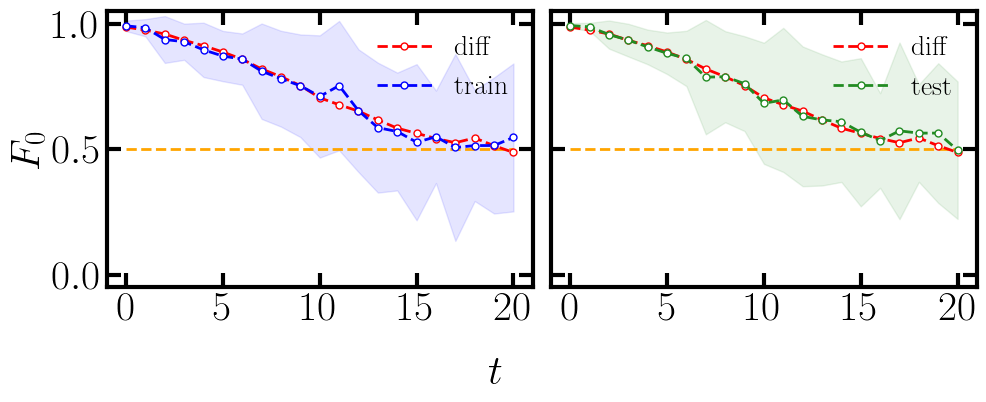

In [48]:
# plot the performance of training
n, na = 1, 1
T = 20
L = 4
Ndata = 100
states_diff = np.load('data/QDDPM/cluster0/n%d/cluster0Diff_n%dT%d_N1000.npy'%(n, n, T))
states_train = np.load('data/QDDPM/cluster0/n%d/QDDPMcluster0trainGen_n%dna%dT%dL%d_nat.npy'
                       %(n, n, na, T, L))
states_test = np.load('data/QDDPM/cluster0/n%d/QDDPMcluster0testGen_n%dna%dT%dL%d_nat.npy'
                      %(n, n, na, T, L))

F0_train = np.abs(states_train[:, :, 0])**2
F0_test = np.abs(states_test[:, :, 0])**2
F0_diff = np.abs(states_diff[:, :, 0])**2

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i in range(2):
    axs[i].plot(range(T+1), np.mean(F0_diff, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
                zorder=5, label=r'$\rm diff$')
    axs[i].plot(range(T+1), 0.5*np.ones(T+1), '--', lw=2, c='orange')

axs[0].plot(range(T+1), np.mean(F0_train, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm train$')
axs[0].fill_between(range(T+1), np.mean(F0_train, axis=1)-np.std(F0_train, axis=1), 
                    np.mean(F0_train, axis=1)+np.std(F0_train, axis=1), color='b', alpha=0.1)

axs[1].plot(range(T+1), np.mean(F0_test, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm test$')
axs[1].fill_between(range(T+1), np.mean(F0_test, axis=1)-np.std(F0_test, axis=1), 
                    np.mean(F0_test, axis=1)+np.std(F0_test, axis=1), color='forestgreen', alpha=0.1)

for i in range(2):
    axs[i].legend(fontsize=20, framealpha=0)
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_xticks(np.arange(0, T+1, 5))
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
axs[0].set_ylabel(r'$F_0$', fontsize=30)
fig.supxlabel(r'$t$', fontsize=30)
plt.tight_layout()
#plt.savefig('figures/QDDPMcluster0Fid_n%dna%dT%dL%d.pdf'%(n, na, T, L), bbox_inches='tight')
plt.show()
plt.close()

In [55]:
states_diff = np.load('data/QDDPM/cluster0/n1/cluster0Diff_n1T20_N1000.npy')
states_train = np.load('data/QDDPM/cluster0/n1/QDDPMcluster0trainGen_n1na1T20L4_nat.npy')
states_test = np.load('data/QDDPM/cluster0/n1/QDDPMcluster0testGen_n1na1T20L4_nat.npy')

F0_train = np.abs(states_train[0, :, 0])**2
F0_test = np.abs(states_test[0, :, 0])**2
F0_diff = np.abs(states_diff[0, :, 0])**2

idx = np.random.choice(1000, 100, replace=False)
np.mean(F0_diff[idx]), np.std(F0_diff[idx]),\
np.mean(F0_train), np.std(F0_train),\
np.mean(F0_test), np.std(F0_test)

(0.9867704, 0.0129681965, 0.9924526, 0.02084307, 0.99284244, 0.014223292)

In [63]:
# plot the dynamics of loss
X = tf.convert_to_tensor(np.load('data/QDDPM/cluster0/n1/cluster0Diff_n1T20_N1000.npy'))
X_train = tf.convert_to_tensor(np.load('data/QDDPM/cluster0/n1/QDDPMcluster0trainGen_n1na1T20L4_nat.npy'))
X_test = tf.convert_to_tensor(np.load('data/QDDPM/cluster0/n1/QDDPMcluster0testGen_n1na1T20L4_nat.npy'))
X0 = tf.convert_to_tensor(cluster0Gen(1, 10000, 0.08, seed=16))

nd = np.zeros((3, 21))
for t in range(21):
    nd[0, t] = naturalDistance(X0, X[t])
    nd[1, t] = naturalDistance(X0, X_train[t])
    nd[2, t] = naturalDistance(X0, X_test[t])
np.save('data/QDDPM/cluster0/n1/QDDPMcluster0Genloss_n1na1T20L4_nat.npy', nd)

[5.25116920e-05 2.81631947e-04 6.21378422e-04]


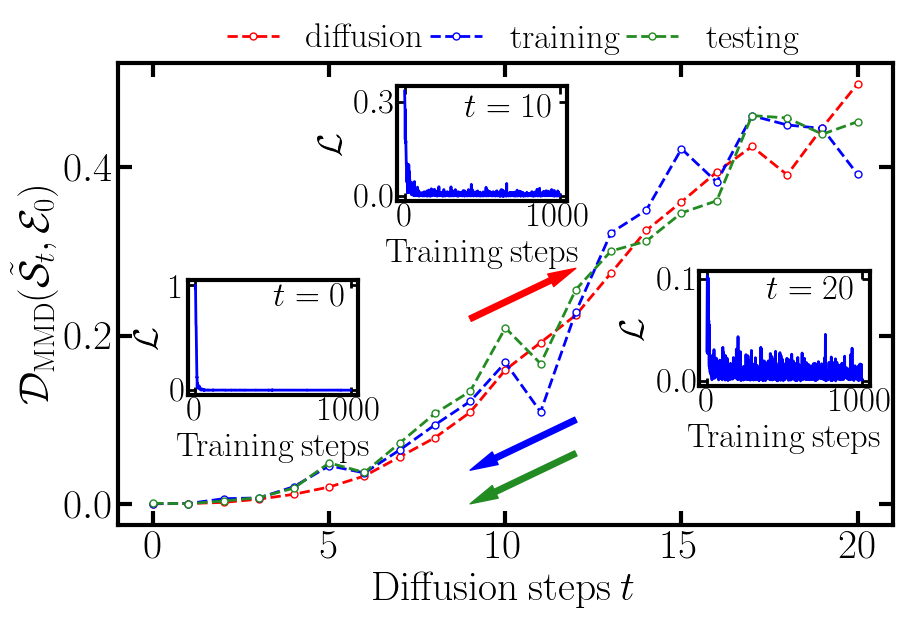

In [7]:
nd_gen = np.load('data/QDDPM/cluster0/n1/QDDPMcluster0Genloss_n1na1T20L4_nat.npy')
loss = np.load('data/QDDPM/cluster0/n1/QDDPMcluster0loss_n1na1T20L4_nat.npy')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(nd_gen[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(nd_gen[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(nd_gen[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')
print(nd_gen[:, 0])
ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.95), fontsize=25, framealpha=0, labelspacing=0.4,
          ncol=3, columnspacing=0.2, handlelength=1.5)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

ax1 = ax.inset_axes([0.09, 0.28, 0.22, 0.25])
ax1.plot(loss[0], lw=2, c='b')
ax1.set_ylabel(r'$\mathcal{L}$', fontsize=25)
ax1.set_xlabel(r'${\rm Training\:steps}$', fontsize=25)
ax1.text(500, 0.8, s=r'$t=0$', fontsize=25)
ax1.tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=25)
ax1.tick_params(axis='both', pad=1)

ax2 = ax.inset_axes([0.36, 0.7, 0.22, 0.25])
ax2.plot(loss[10], lw=2, c='b')
ax2.set_ylabel(r'$\mathcal{L}$', fontsize=25)
ax2.set_xlabel(r'${\rm Training\:steps}$', fontsize=25)
ax2.set_yticks([0, 0.3])
ax2.text(380, 0.25, s=r'$t=10$', fontsize=25)
ax2.tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=25)
ax2.tick_params(axis='both', pad=1)

ax3 = ax.inset_axes([0.75, 0.3, 0.22, 0.25])
ax3.plot(loss[-1], lw=2, c='b')
ax3.set_ylabel(r'$\mathcal{L}$', fontsize=25)
ax3.set_xlabel(r'${\rm Training\:steps}$', fontsize=25)
ax3.text(380, 0.08, s=r'$t=20$', fontsize=25)
ax3.tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=25)
ax3.tick_params(axis='both', pad=1)

ax.annotate(text='', xy=(12, 0.28), xytext=(9, 0.22), 
                arrowprops=dict(width=4, color='r', headwidth=10, headlength=20))
ax.annotate(text='', xy=(9, 0.04), xytext=(12, 0.1), 
                arrowprops=dict(width=4, color='b', headwidth=10, headlength=20))
ax.annotate(text='', xy=(9, 0), xytext=(12, 0.06), 
                arrowprops=dict(width=4, color='forestgreen', headwidth=10, headlength=20))

plt.savefig('figures/QDDPMcluster0loss_n1.pdf', bbox_inches='tight')
plt.show()
plt.close()

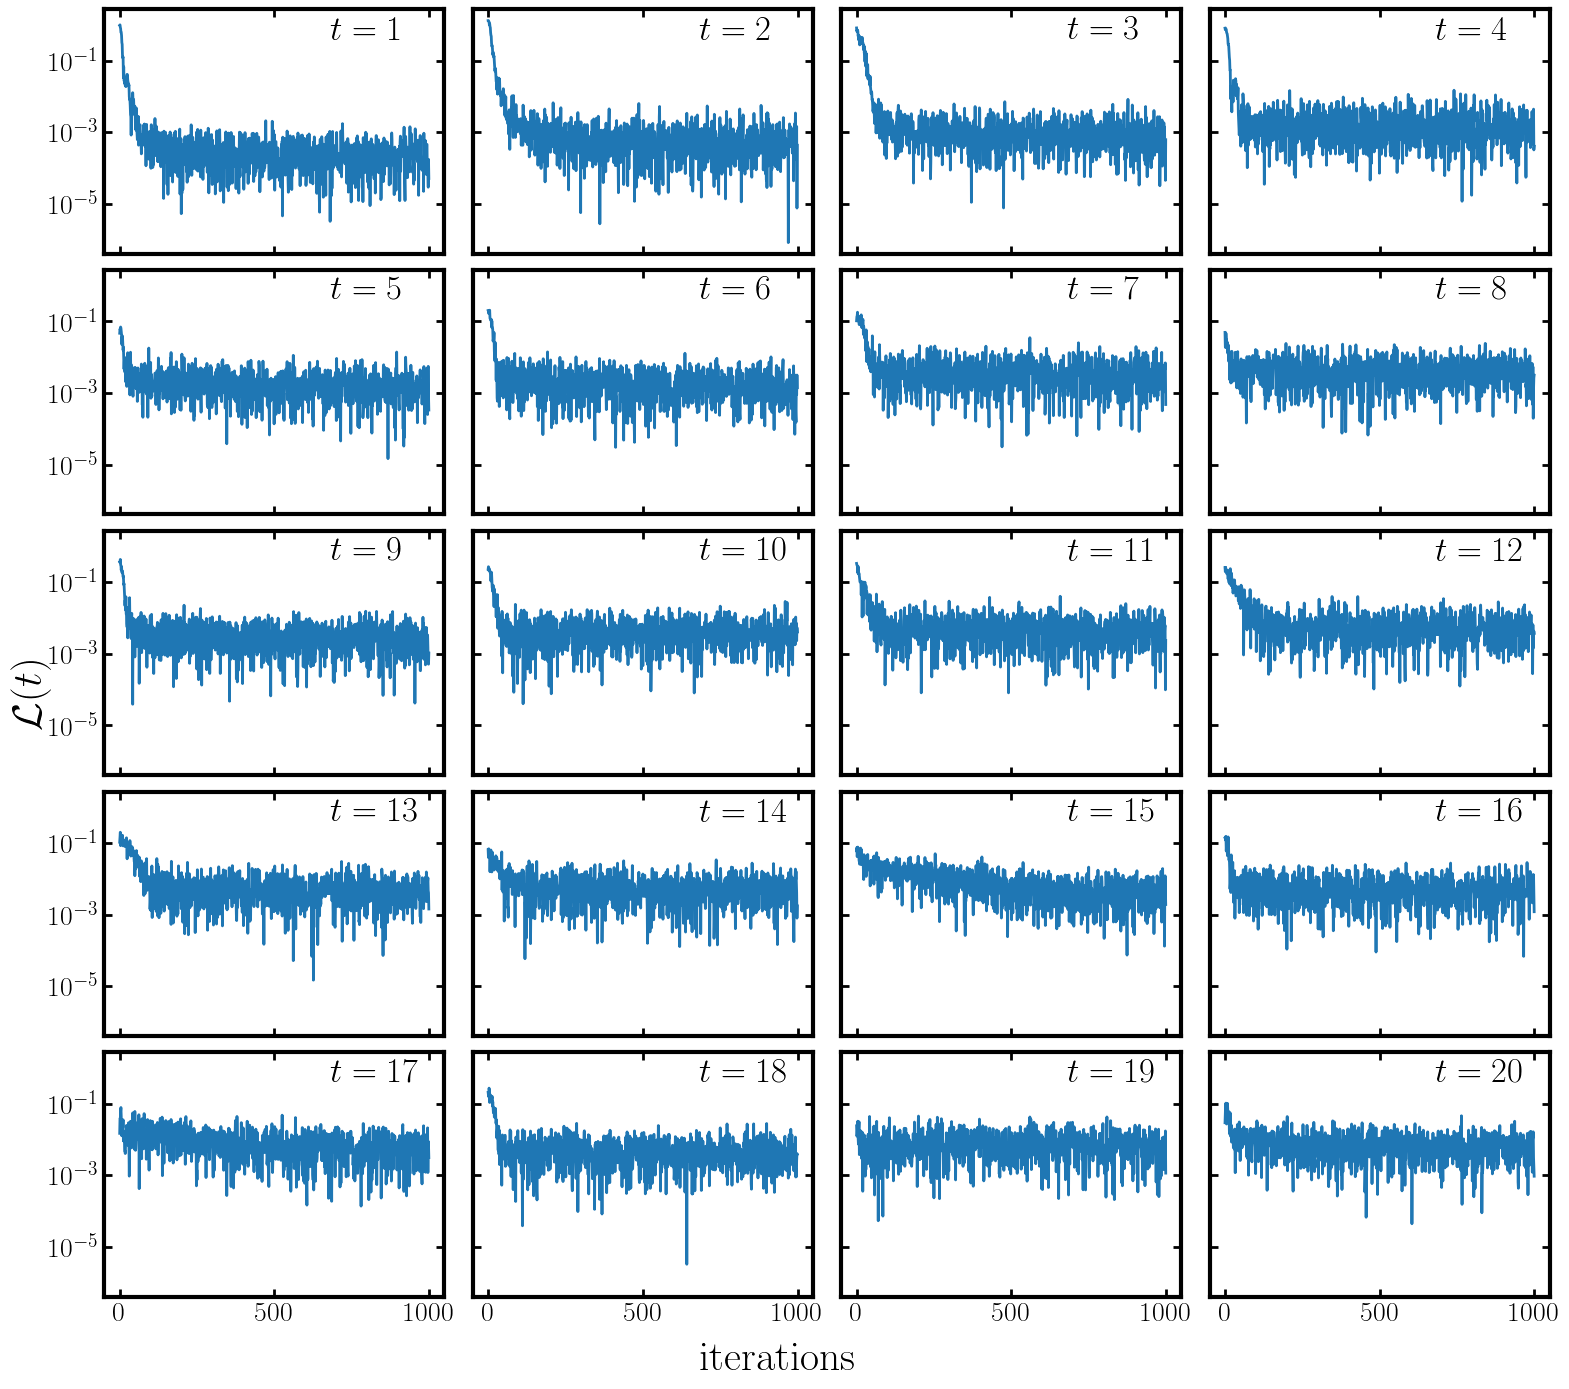

In [5]:
# plot training loss history
n, na = 1, 1
T = 20
L = 4
loss = np.load('data/QDDPM/cluster0/n1/QDDPMcluster0loss_n1na1T20L4_nat.npy')
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(loss[i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=680, y=0.4, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//4, i%4].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()
plt.savefig('figures/QDDPMcluster0loss_n%dna%dT%dL%d.pdf'%(n, na, T, L), bbox_inches='tight')
plt.show()
plt.close()

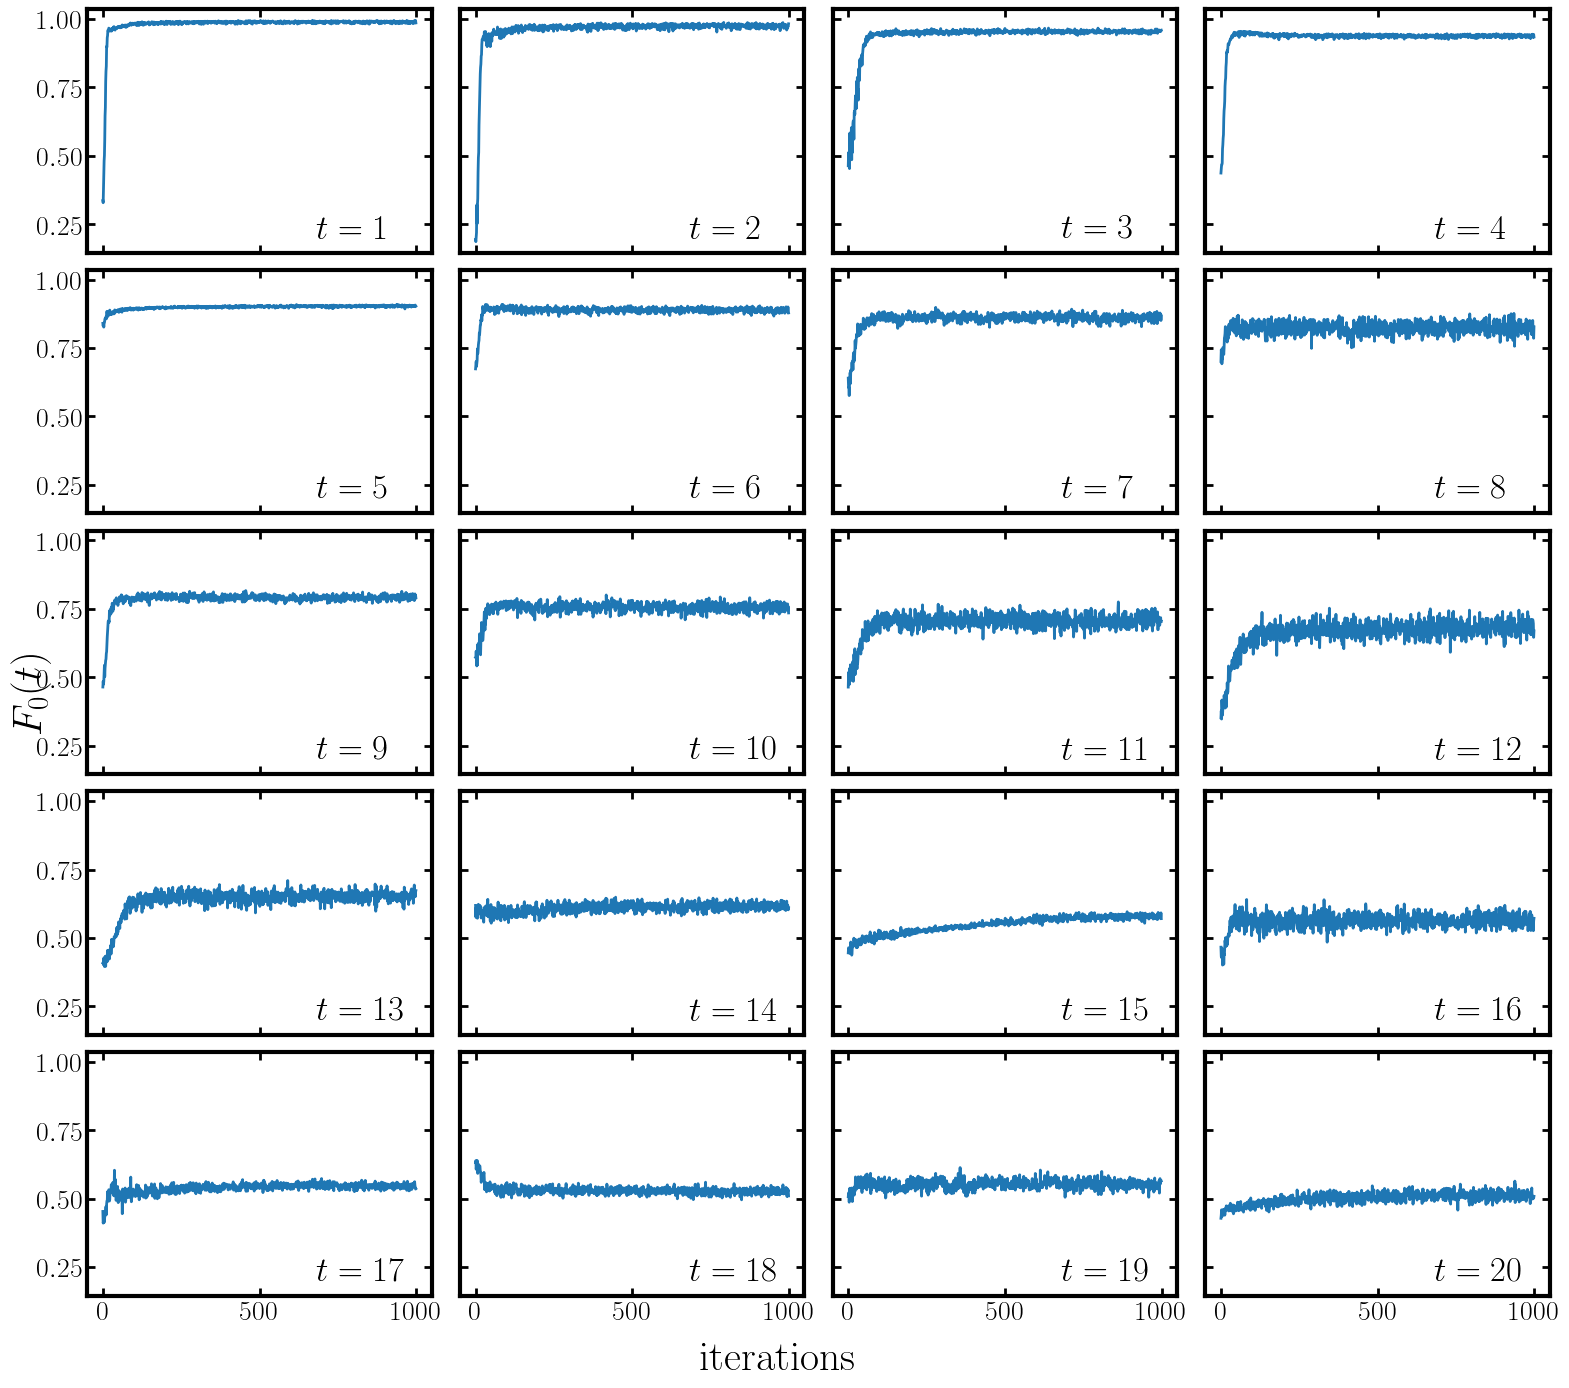

In [33]:
# plot fidelity history in traning
n, na = 1, 1
T = 20
L = 4
f0 = np.load('data/QDDPM/cluster0/n1/QDDPMcluster0f0_n1na1T20L4_nat.npy')
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(f0[i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=680, y=0.2, s=r'$t=%d$'%(i+1), fontsize=25)
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$F_0(t)$', fontsize=30)
plt.tight_layout()

In [13]:
# Wasserstein loss
n, na = 1, 1
T = 20
L = 4
Ndata = 100
method = 'wd'

diffModel = OneQubitDiffusionModel(T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=42)
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=28)

params_tot = np.load('data/QDDPM/cluster0/n%d/QDDPMcluster0params_n%dna%dT%dL%d_%s.npy'
                     %(n, n, na, T, L, method))

with tf.device('cpu'):
    model = QDDPM(n=n, na=na, T=T, L=L)

    dataset_train = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n].numpy()
    dataset_test = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n].numpy()
    
    np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0trainGen_n%dna%dT%dL%d_%s.npy'
            %(n, n, na, T, L, method), dataset_train)
    np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0testGen_n%dna%dT%dL%d_%s.npy'
            %(n, n, na, T, L, method), dataset_test)

In [17]:
X = tf.convert_to_tensor(np.load('data/QDDPM/cluster0/n1/cluster0Diff_n1T20_N1000.npy'))
X_train = tf.convert_to_tensor(np.load('data/QDDPM/cluster0/n1/QDDPMcluster0trainGen_n1na1T20L4_wd.npy'))
X_test = tf.convert_to_tensor(np.load('data/QDDPM/cluster0/n1/QDDPMcluster0testGen_n1na1T20L4_wd.npy'))
X0 = tf.convert_to_tensor(cluster0Gen(1, 10000, 0.08, seed=16))

nd = np.zeros((3, 21))
for t in range(21):
    nd[0, t] = WassDistance(X0, X[t])
    nd[1, t] = WassDistance(X0, X_train[t])
    nd[2, t] = WassDistance(X0, X_test[t])
np.save('data/QDDPM/cluster0/n1/QDDPMcluster0Genloss_n1na1T20L4_wd.npy', nd)

c:\Users\Bingzhi\envs\tensorCircuit_tf\lib\site-packages\ot\lp\__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


[0.00020377 0.01543846 0.01613263]


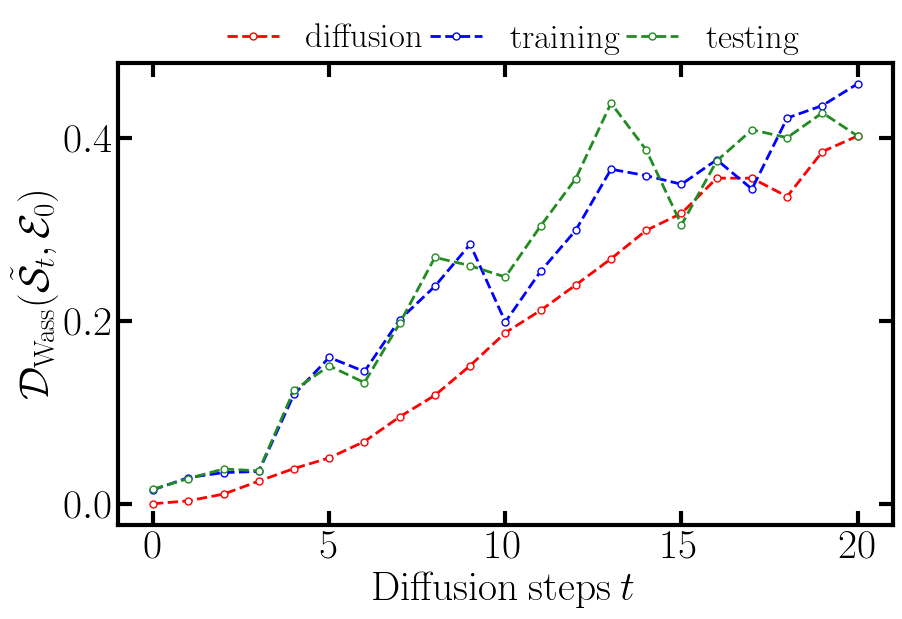

In [19]:
nd_gen = np.load('data/QDDPM/cluster0/n1/QDDPMcluster0Genloss_n1na1T20L4_wd.npy')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(nd_gen[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(nd_gen[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(nd_gen[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')
print(nd_gen[:, 0])
ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.95), fontsize=25, framealpha=0, labelspacing=0.4,
          ncol=3, columnspacing=0.2, handlelength=1.5)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm Wass}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

# 2-qubit cluster problem

In [6]:
# generate dfifusion data set
n = 2
T = 20
N = 1000

with tf.device('cpu'):
    diff_hs = np.linspace(0.5, 4., T)
    model_diff = MultiQubitDiffusionModel(n, T, N)
    X = tf.convert_to_tensor(cluster0Gen(2, 1000, 0.06, seed=12))
    Xout = np.zeros((T+1, N, 2**n), dtype=np.complex64)
    Xout[0] = X
    for t in range(1, T+1):
        Xout[t] = model_diff.set_diffusionDataMulti_t(t, X, diff_hs[:t], seed=t).numpy()
#np.save('data/QDDPM/cluster0/n2/cluster0Diff_n2T20_N%d.npy'%N, Xout)

In [10]:
np.mean(np.abs(X[:, 0])**2), np.std(np.abs(X[:, 0])**2)

(0.9792449, 0.011440034)

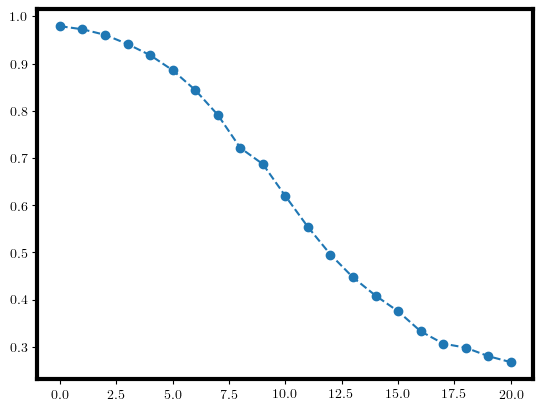

In [8]:
#Xout = np.load('data/QDDPM/cluster0/n2/cluster0Diff_n2T20_N1000.npy')
np.mean(np.abs(Xout[:,:,0])**2, axis=1)
plt.plot(np.mean(np.abs(Xout[:,:,0])**2, axis=1), 'o--')

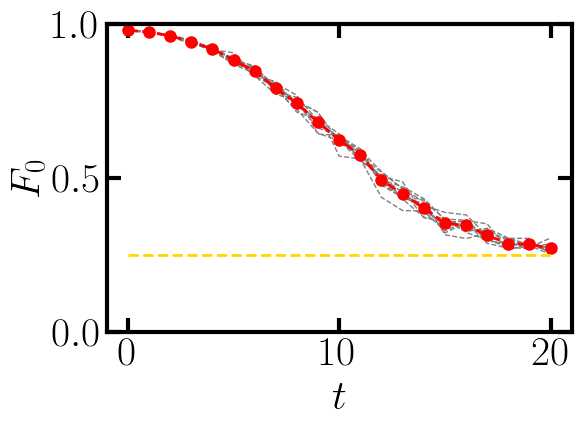

In [7]:
# visualize the fidelity decay in the diffusion process
n = 2
T = 20
N = 1000
states_diff = np.load('data/QDDPM/cluster0/n%d/cluster0Diff_n%dT%d_N%d.npy'%(n, n, T, N))
fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(1000)
for i in range(10):
    ax.plot(range(T+1), np.mean(np.abs(states_diff[:, indices[100*i:100*(i+1)], 0])**2, axis=1),
            '--', lw=1, c='grey')
ax.plot(range(T+1), np.mean(np.abs(states_diff[:,:,0])**2, axis=1), 'o--', markersize=8, lw=2, c='r')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='gold')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
plt.show()
plt.close()

## Generate trainig and testing data

In [4]:
# collect trainining result
n, na = 2, 1
T = 20
L = 6
Ndata = 100
epochs = 2000
method = 'nat'

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))
f0_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('data/QDDPM/cluster0/n%d/record/QDDPMcluster0params_n%dna%dT%dL%d_t%d_%s.npy'
                            %(n, n, na, T, L, t, method))
    loss_tot[t] = np.load('data/QDDPM/cluster0/n%d/record/QDDPMcluster0loss_n%dna%dT%dL%d_t%d_%s.npy'
                            %(n, n, na, T, L, t, method))
    f0_tot[t] = np.load('data/QDDPM/cluster0/n%d/record/QDDPMcluster0f0_n%dna%dT%dL%d_t%d_%s.npy'
                            %(n, n, na, T, L, t, method))
np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0params_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method), params_tot)
np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0loss_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method), loss_tot)
np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0f0_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method), f0_tot)

In [74]:
# generate training & test data
n, na = 2, 1
T = 20
L = 6
Ndata = 100
method = 'nat'

params_tot = np.load('data/QDDPM/cluster0/n2/QDDPMcluster0params_n2na1T20L6_nat.npy')

diffModel = MultiQubitDiffusionModel(n, T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22)
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=23)

with tf.device('cpu'):
    model = QDDPM(n=n, na=na, T=T, L=L)

    dataset_train = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n].numpy()
    dataset_test = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n].numpy()
    np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0trainGen_n%dna%dT%dL%d_%s.npy'
            %(n, n, na, T, L, method), dataset_train)
    np.save('data/QDDPM/cluster0/n%d/QDDPMcluster0testGen_n%dna%dT%dL%d_%s.npy'
            %(n, n, na, T, L, method), dataset_test)

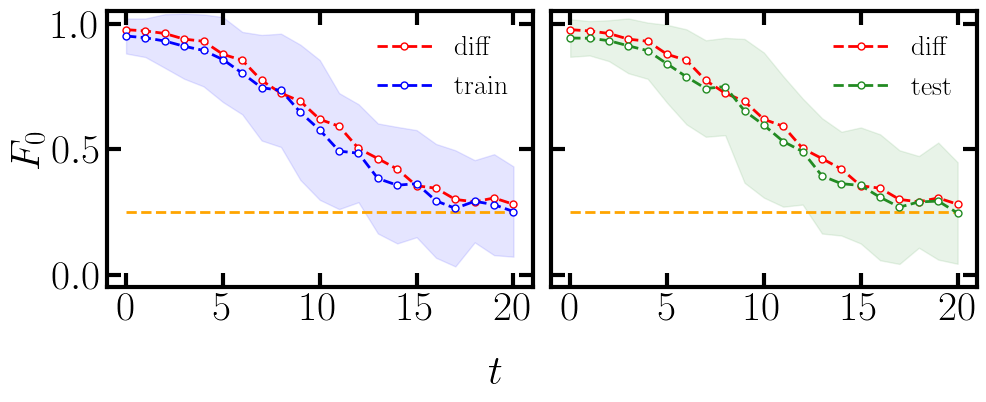

In [76]:
# plot the performance of training
n, na = 2, 1
T = 20
L = 6
Ndata = 100
states_diff = np.load('data/QDDPM/cluster0/n%d/cluster0Diff_n%dT%d_N1000.npy'%(n, n, T))
states_train = np.load('data/QDDPM/cluster0/n%d/QDDPMcluster0trainGen_n%dna%dT%dL%d_nat.npy'%(n, n, na, T, L))
states_test = np.load('data/QDDPM/cluster0/n%d/QDDPMcluster0testGen_n%dna%dT%dL%d_nat.npy'%(n, n, na, T, L))

F0_train = np.abs(states_train[:, :, 0])**2
F0_test = np.abs(states_test[:, :, 0])**2
F0_diff = np.abs(states_diff[:, :Ndata, 0])**2

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i in range(2):
    axs[i].plot(range(T+1), np.mean(F0_diff, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
                zorder=5, label=r'$\rm diff$')
    axs[i].plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='orange')

axs[0].plot(range(T+1), np.mean(F0_train, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm train$')
axs[0].fill_between(range(T+1), np.mean(F0_train, axis=1)-np.std(F0_train, axis=1), 
                    np.mean(F0_train, axis=1)+np.std(F0_train, axis=1), color='b', alpha=0.1)

axs[1].plot(range(T+1), np.mean(F0_test, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm test$')
axs[1].fill_between(range(T+1), np.mean(F0_test, axis=1)-np.std(F0_test, axis=1), 
                    np.mean(F0_test, axis=1)+np.std(F0_test, axis=1), color='forestgreen', alpha=0.1)

for i in range(2):
    axs[i].legend(fontsize=20, framealpha=0)
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_xticks(np.arange(0, T+1, 5))
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
axs[0].set_ylabel(r'$F_0$', fontsize=30)
fig.supxlabel(r'$t$', fontsize=30)
plt.tight_layout()
#plt.savefig('figures/QDDPMcluster0Fid_n%dna%dT%dL%d.pdf'%(n, na, T, L), bbox_inches='tight')
plt.show()
plt.close()

In [75]:
states_diff = np.load('data/QDDPM/cluster0/n2/cluster0Diff_n2T20_N1000.npy')
states_train = np.load('data/QDDPM/cluster0/n2/QDDPMcluster0trainGen_n2na1T20L6_nat.npy')
states_test = np.load('data/QDDPM/cluster0/n2/QDDPMcluster0testGen_n2na1T20L6_nat.npy')

F0_train = np.abs(states_train[0, :, 0])**2
F0_test = np.abs(states_test[0, :, 0])**2
F0_diff = np.abs(states_diff[0, :, 0])**2

idx = np.random.choice(1000, 100, replace=False)
np.mean(F0_diff[idx]), np.std(F0_diff[idx]),\
np.mean(F0_train), np.std(F0_train),\
np.mean(F0_test), np.std(F0_test)

(0.97697145, 0.012352723, 0.95194566, 0.06973477, 0.94383764, 0.07477042)

In [72]:
# plot the dynamics of loss
X = tf.convert_to_tensor(np.load('data/QDDPM/cluster0/n2/cluster0Diff_n2T20_N1000.npy'))
X_train = tf.convert_to_tensor(np.load('data/QDDPM/cluster0/n2/QDDPMcluster0trainGen_n2na1T20L6_nat.npy'))
X_test = tf.convert_to_tensor(np.load('data/QDDPM/cluster0/n2/QDDPMcluster0testGen_n2na1T20L6_nat.npy'))
X0 = tf.convert_to_tensor(cluster0Gen(2, 10000, 0.06, seed=12))

nd = np.zeros((3, 21))
for t in range(21):
    nd[0, t] = naturalDistance(X0, X[t])
    nd[1, t] = naturalDistance(X0, X_train[t])
    nd[2, t] = naturalDistance(X0, X_test[t])
np.save('data/QDDPM/cluster0/n2/QDDPMcluster0Genloss_n2na1T20L6_nat.npy', nd)

In [ ]:
nd_gen = np.load('data/QDDPM/cluster0/n2/QDDPMcluster0Genloss_n2na1T20L6_nat.npy')
loss = np.load('data/QDDPM/cluster0/n2/QDDPMcluster0loss_n2na1T20L6_nat.npy')

fig, ax = plt.subplots(figsize=(10, 6))
#gs = GridSpec(12, 16, figure=fig)

# ax0 = plt.subplot(gs[0:6, :])
# ax1 = plt.subplot(gs[7:, :6])  # First column of the second row
# #ax2 = plt.subplot(gs[7:, 5:9])  # Second column of the second row
# ax2 = plt.subplot(gs[7:, 8:])
# #ax3 = plt.subplot(gs[7:, 10:])  # Third column of the second row

ax.plot(nd_gen[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(nd_gen[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(nd_gen[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')
#ax.legend(loc='lower left', bbox_to_anchor=(0., 0.15), fontsize=25, framealpha=0, labelspacing=0.4)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

ax1 = ax.inset_axes([0.09, 0.2, 0.22, 0.25])
ax1.plot(loss[0], lw=2, c='b')
ax1.set_ylabel(r'$\mathcal{L}$', fontsize=25)
ax1.set_xlabel(r'${\rm Training\:steps}$', fontsize=25)
ax1.text(1000, 1.1, s=r'$t=0$', fontsize=25)
ax1.tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=25)
ax1.tick_params(axis='both', pad=1)

ax2 = ax.inset_axes([0.36, 0.63, 0.22, 0.25])
ax2.plot(loss[10], lw=2, c='b')
ax2.set_ylabel(r'$\mathcal{L}$', fontsize=25)
ax2.set_xlabel(r'${\rm Training\:steps}$', fontsize=25)
ax2.text(800, 0.3, s=r'$t=10$', fontsize=25)
ax2.set_yticks([0, 0.3])
ax2.tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=25)
ax2.tick_params(axis='both', pad=1)

ax3 = ax.inset_axes([0.75, 0.4, 0.22, 0.25])
ax3.plot(loss[-1], lw=2, c='b')
ax3.set_ylabel(r'$\mathcal{L}$', fontsize=25)
ax3.set_xlabel(r'${\rm Training\:steps}$', fontsize=25)
ax3.text(800, 0.08, s=r'$t=20$', fontsize=25)
ax3.tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=25)
ax3.tick_params(axis='both', pad=1)

ax.annotate(text='', xy=(1, 0.1), xytext=(0, 0.02), arrowprops={"linestyle" : "--",
            "shrinkA": 0, "shrinkB": 0, 'color':'blue', 'linewidth':0.5})
ax.annotate(text='', xy=(10, 0.4), xytext=(10, 0.25), arrowprops={"linestyle" : "--",
            "shrinkA": 0, "shrinkB": 0, 'color':'blue', 'linewidth':0.5})
ax.annotate(text='', xy=(18, 0.5), xytext=(20, 0.65), arrowprops={"linestyle" : "--",
            "shrinkA": 0, "shrinkB": 0, 'color':'blue', 'linewidth':0.5})
plt.savefig('figures/QDDPMcluster0loss_n2.pdf', bbox_inches='tight')
plt.show()
plt.close()

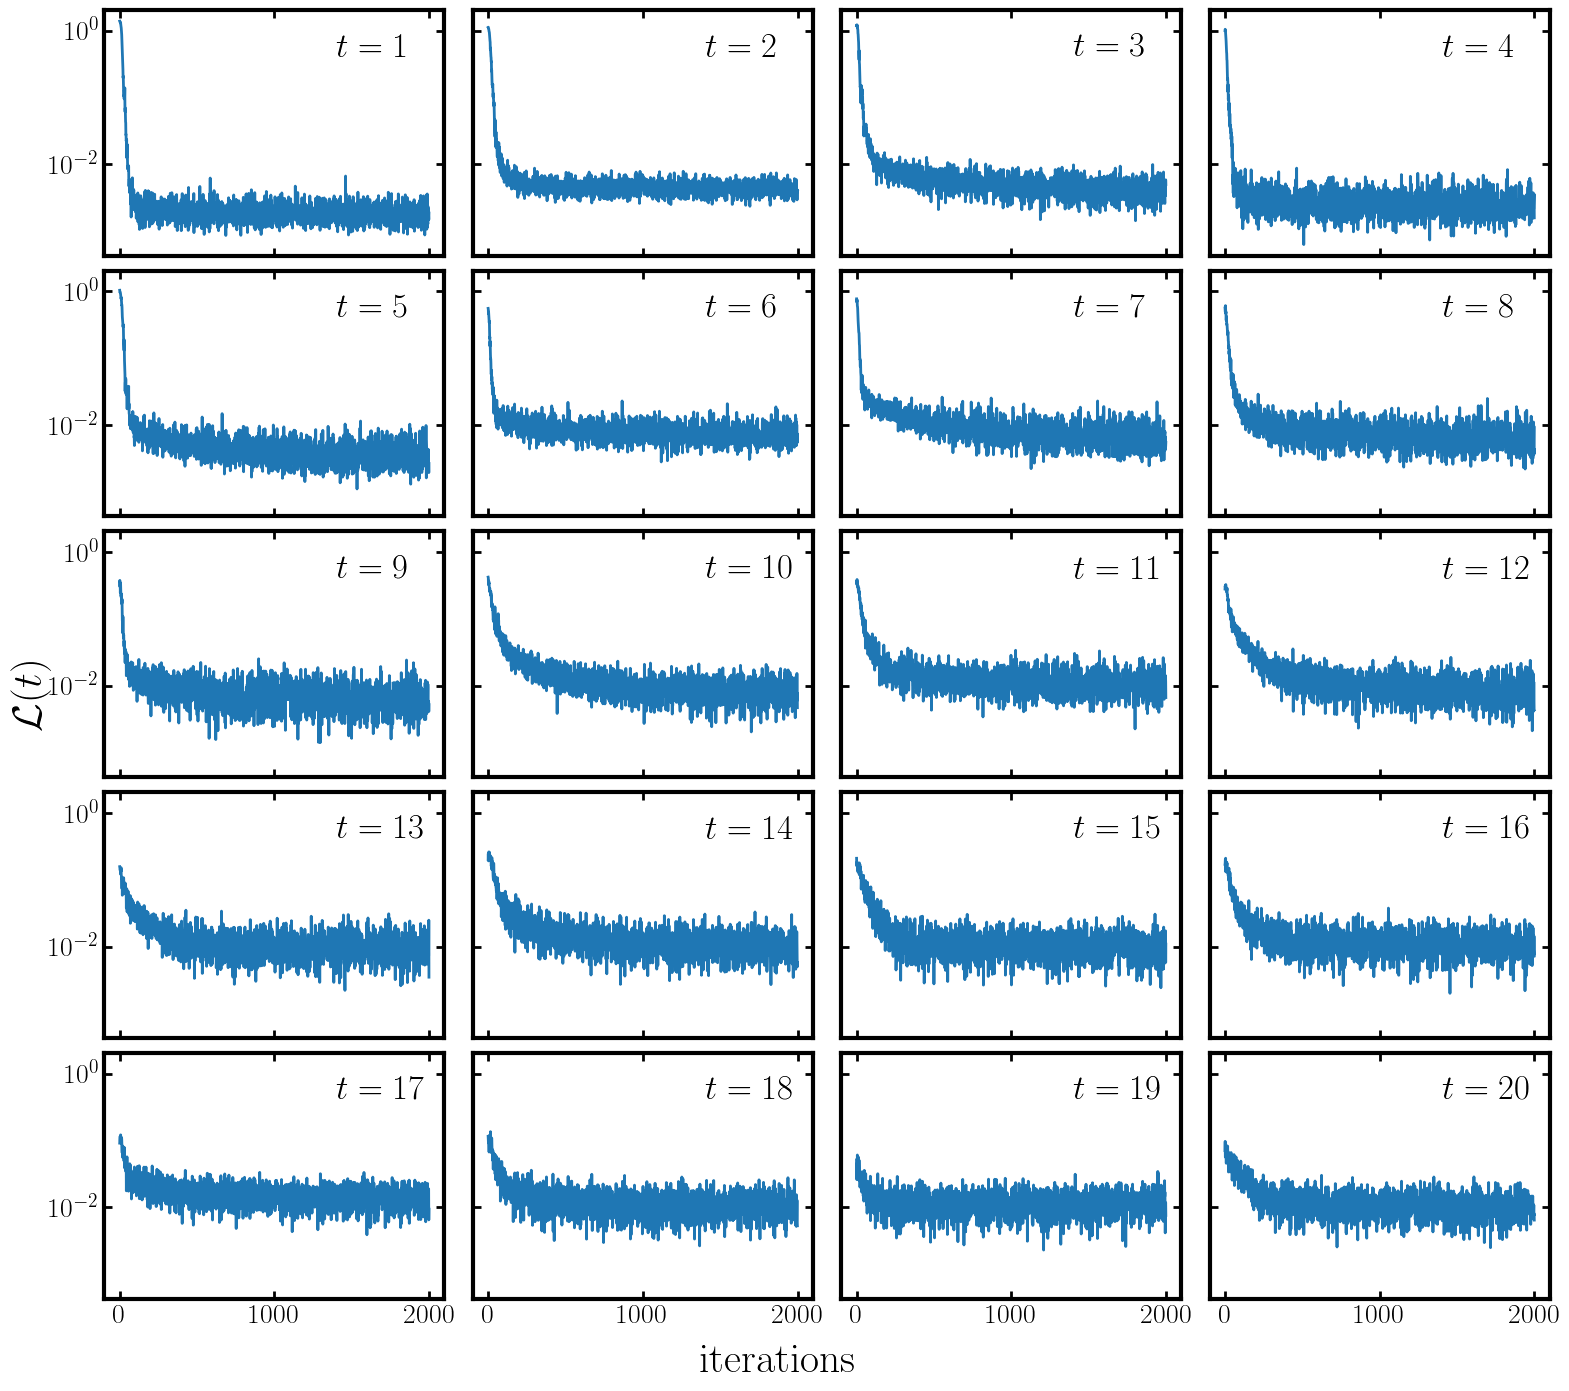

In [9]:
# plot training loss history
n, na = 2, 1
T = 20
L = 6
loss = np.load('data/QDDPM/cluster0/n2/QDDPMcluster0loss_n2na1T20L6_nat.npy')
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(loss[i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=1400, y=0.4, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//4, i%4].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()
plt.savefig('figures/QDDPMcluster0loss_n%dna%dT%dL%d.pdf'%(n, na, T, L), bbox_inches='tight')
plt.show()
plt.close()

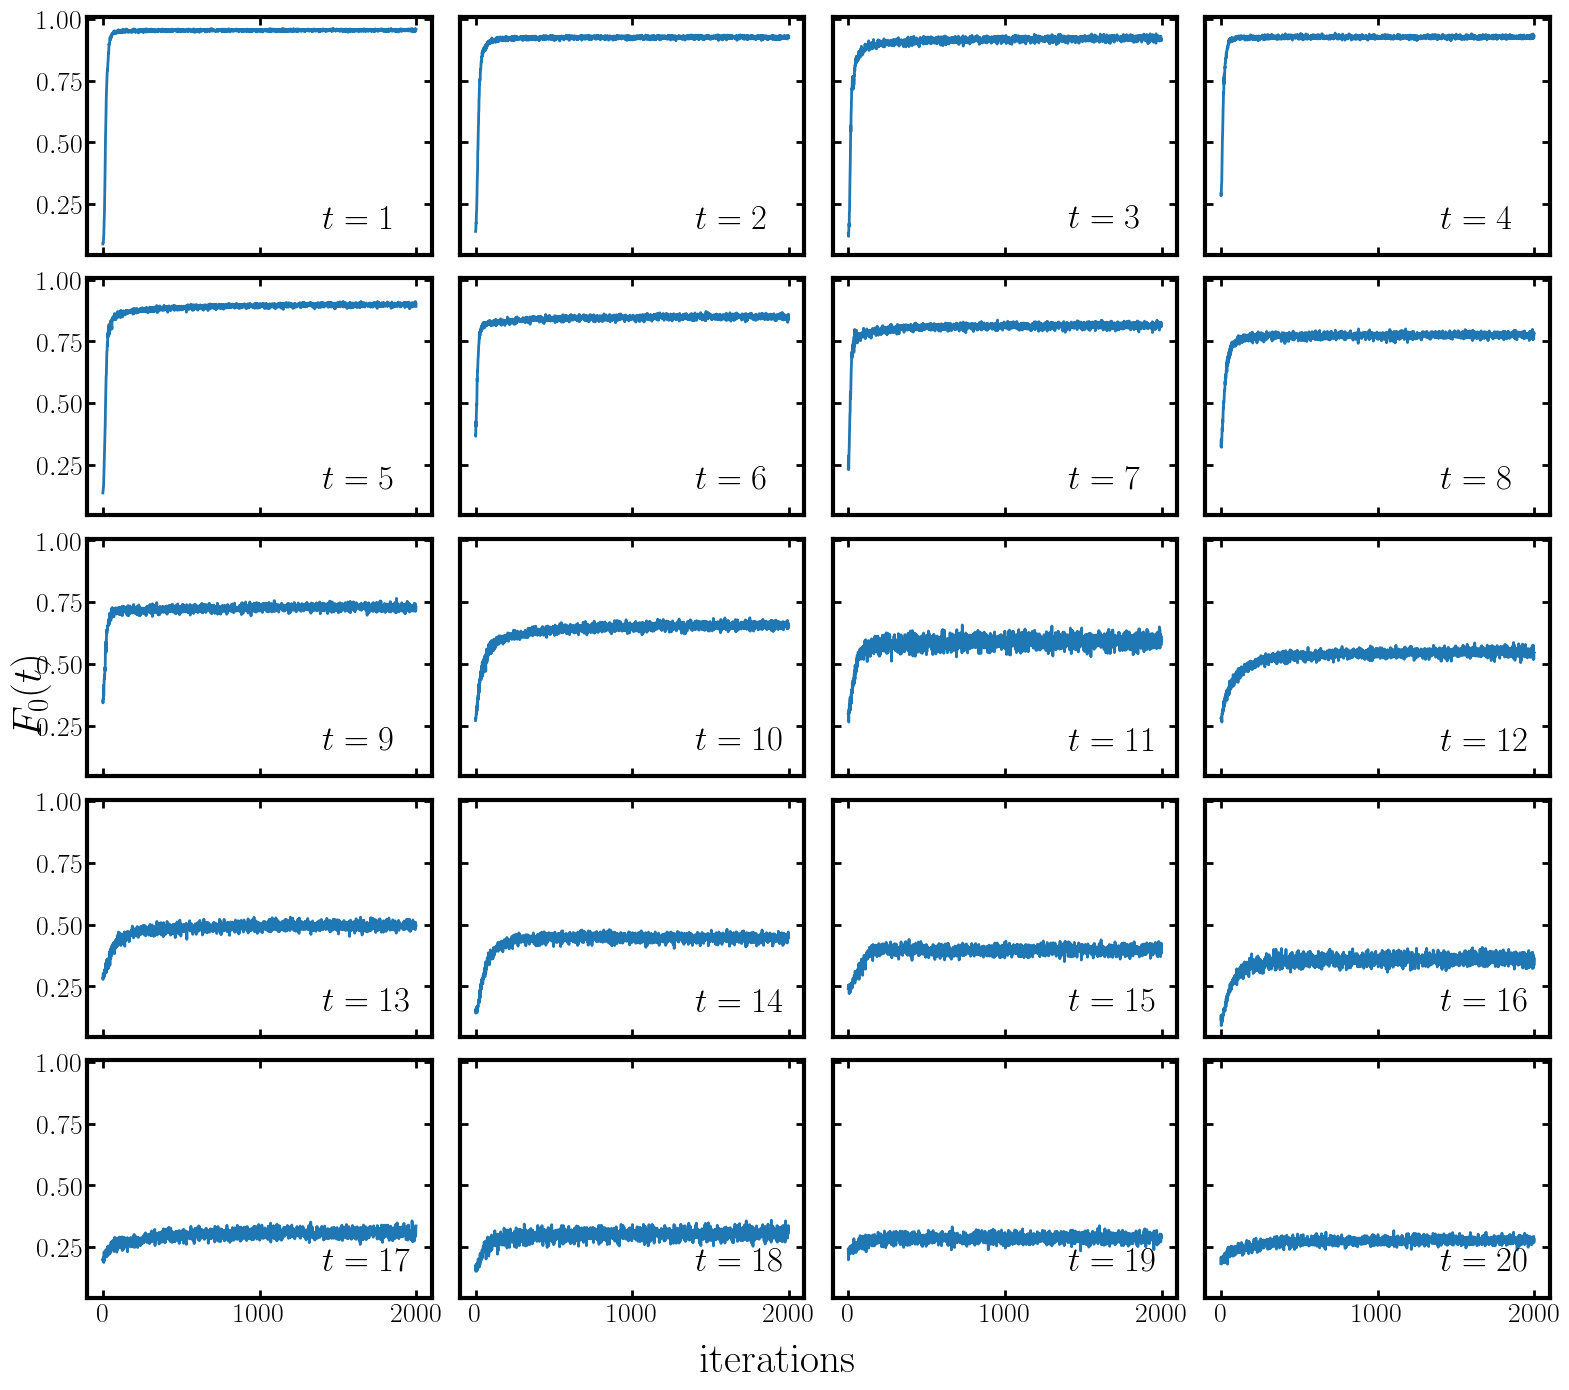

In [11]:
# plot fidelity history in traning
n, na = 2, 1
T = 20
L = 6
f0 = np.load('data/QDDPM/cluster0/n2/QDDPMcluster0f0_n2na1T20L6_nat.npy')
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(f0[i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=1400, y=0.15, s=r'$t=%d$'%(i+1), fontsize=25)
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$F_0(t)$', fontsize=30)
plt.tight_layout()

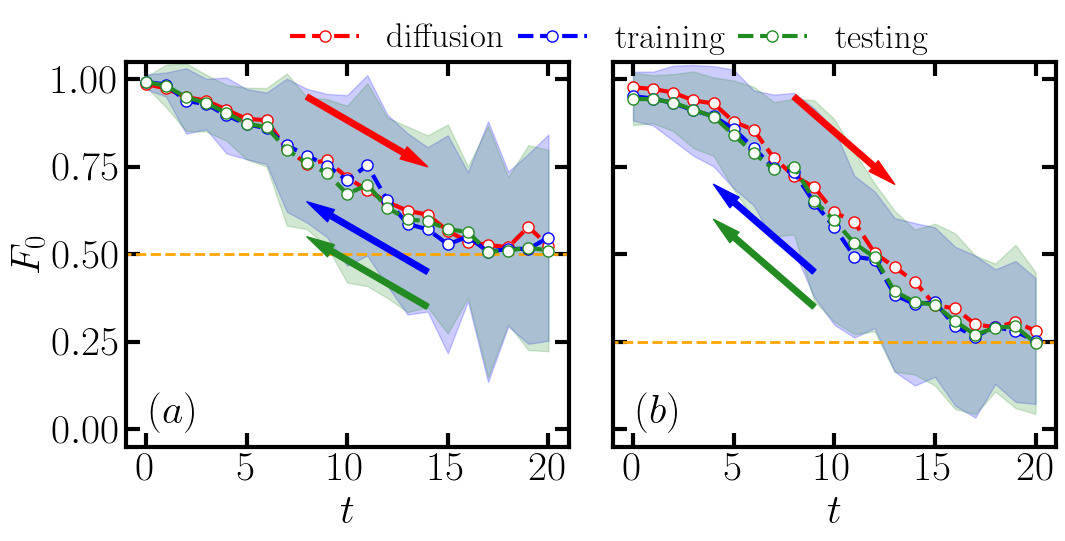

In [2]:
# plot the performance of training for both 1 and 2 qubit
na = 1
ns = [1, 2]
Ls = [4, 6]
T = 20
Ndata = 100

F0_diff = np.zeros((2, T+1, Ndata))
F0_train = np.zeros((2, T+1, Ndata))
F0_test = np.zeros((2, T+1, Ndata))
for i in range(2):
    n = ns[i]
    L = Ls[i]
    states_diff = np.load('data/QDDPM/cluster0/n%d/cluster0Diff_n%dT%d_N1000.npy'%(n, n, T))
    states_train = np.load('data/QDDPM/cluster0/n%d/QDDPMcluster0trainGen_n%dna%dT%dL%d_nat.npy'%(n, n, na, T, L))
    states_test = np.load('data/QDDPM/cluster0/n%d/QDDPMcluster0testGen_n%dna%dT%dL%d_nat.npy'%(n, n, na, T, L))

    F0_diff[i] = np.abs(states_diff[:, :Ndata, 0])**2
    F0_train[i] = np.abs(states_train[:, :, 0])**2
    F0_test[i] = np.abs(states_test[:, :, 0])**2
    
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for i in range(2):
    axs[i].plot(range(T+1), np.mean(F0_diff[i], axis=1), 'o--', markersize=8, mfc='white', lw=3, 
                c='r', zorder=5, label=r'$\rm diffusion$')
    axs[i].plot(range(T+1), np.mean(F0_train[i], axis=1), 'o--', markersize=8, mfc='white', lw=3, 
                c='b', zorder=5, label=r'$\rm training$')
    axs[i].fill_between(range(T+1), np.mean(F0_train[i], axis=1)-np.std(F0_train[i], axis=1), 
            np.mean(F0_train[i], axis=1)+np.std(F0_train[i], axis=1), color='b', alpha=0.2)
    axs[i].plot(range(T+1), np.mean(F0_test[i], axis=1), 'o--', markersize=8, mfc='white', 
                lw=3, c='forestgreen', zorder=5, label=r'$\rm testing$')
    axs[i].fill_between(range(T+1), np.mean(F0_test[i], axis=1)-np.std(F0_test[i], axis=1), 
            np.mean(F0_test[i], axis=1)+np.std(F0_test[i], axis=1), color='forestgreen', 
            alpha=0.2)
    
axs[0].hlines(0.5, xmin=-2, xmax=22, ls='--', lw=2, color='orange')
axs[1].hlines(0.25, xmin=-2, xmax=22, ls='--', lw=2, color='orange')
axs[0].legend(loc='upper left', bbox_to_anchor=(0.3, 1.18), fontsize=25, framealpha=0, 
              ncol=3, columnspacing=0.4)
for i in range(2):
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_xlim(-1, 21)
    axs[i].set_xlabel(r'$t$', fontsize=30)
    axs[i].set_yticks(np.arange(5)*0.25)
    axs[i].set_xticks(np.arange(0, T+1, 5))
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
axs[0].set_ylabel(r'$F_0$', fontsize=30)
axs[0].text(x=0.2, y=0.02, s=r'$(a)$', fontsize=30)
axs[1].text(x=0.2, y=0.02, s=r'$(b)$', fontsize=30)
axs[0].annotate(text='', xy=(14, 0.75), xytext=(8, 0.95), arrowprops=dict(width=4, color='r', headwidth=10, headlength=20))
axs[0].annotate(text='', xy=(8, 0.65), xytext=(14, 0.45), arrowprops=dict(width=4, color='b', headwidth=10, headlength=20))
axs[0].annotate(text='', xy=(8, 0.55), xytext=(14, 0.35), arrowprops=dict(width=4, color='forestgreen', headwidth=10, headlength=20))
axs[1].annotate(text='', xy=(13, 0.7), xytext=(8, 0.95), arrowprops=dict(width=4, color='r', headwidth=10, headlength=20))
axs[1].annotate(text='', xy=(4, 0.7), xytext=(9, 0.45), arrowprops=dict(width=4, color='b', headwidth=10, headlength=20))
axs[1].annotate(text='', xy=(4, 0.6), xytext=(9, 0.35), arrowprops=dict(width=4, color='forestgreen', headwidth=10, headlength=20))
plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/QDDPMcluster.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [4]:
np.mean(F0_diff[:, 0], axis=1), np.std(F0_diff[:, 0], axis=1),\
np.mean(F0_train[:, 0], axis=1), np.std(F0_train[:, 0], axis=1),\
np.mean(F0_test[:, 0], axis=1), np.std(F0_test[:, 0], axis=1)

(array([0.98659067, 0.9772121 ]),
 array([0.01315122, 0.01423472]),
 array([0.99245266, 0.95194567]),
 array([0.02084307, 0.06973477]),
 array([0.99284238, 0.94383771]),
 array([0.01422329, 0.07477042]))

# Constrast to QDT (direct transport)

In [32]:
def QDTtraining(model, Ndata, epochs, dis_measure='nat', dis_params={}):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    dis_measure: the distance measure to compare two distributions of quantum states
    dis_params: potential hyper-parameters for distance measure
    '''
    input_tplus1 = torch.zeros((Ndata, 2**model.n_tot)).cfloat()
    input_tplus1[:,:2**model.n] = model.randomSampleGeneration(Ndata) # prepare input

    loss_hist = [] # record of training history
    f0_hist = [] # record of fidelity history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.randn(2*model.n_tot*model.L), dtype=torch.float32, requires_grad=True)
    
    # set optimizer and learning rate decay
    optimizer = torch.optim.SGD(params=(params_t, ), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=400, gamma=0.5)
    #optimizer = torch.optim.Adam(params=(params_t, ), lr=0.001)

    for step in range(epochs):
        optimizer.zero_grad()
        indices = np.random.choice(model.states_diff.shape[1], size=Ndata, replace=False)
        true_data = model.states_diff[0, indices]
        output_t = model.backwardOutput_t(input_tplus1, params_t, mseq=False)
        if dis_measure == 'nat':
            # natural distance
            loss = naturalDistance(output_t, true_data)
        elif dis_measure == 'wd':
            # Wassastein distance
            loss = WassDistance(output_t, true_data)
        elif dis_measure == 'shd':
            # sinkhorn distance
            loss = sinkhornDistance(output_t, true_data, reg=dis_params['reg'], log=dis_params['log'])

        loss_hist.append(loss.detach()) # record the current loss
        f0_hist.append(torch.mean(torch.abs(output_t.detach()[:,0])**2)) # record current fidelity
        
        if (step+1)%100 == 0 or not step:
            print(step+1, loss_hist[step], f0_hist[step])
        loss.backward()
        optimizer.step()
        scheduler.step()
    return params_t.detach(), torch.stack(loss_hist).squeeze(), torch.stack(f0_hist).squeeze()

## 1-qubit

In [33]:
n, na = 1, 1
T = 20
L = 80
Ndata = 100
epochs = 500
method = 'nat'

states_diff = np.load('data/QDDPM/cluster0/n%d/cluster0Diff_n%dT%d_N1000.npy'%(n, n, T))

model = QDDPM_cpu(n=n, na=na, T=1, L=L)
model.set_diffusionSet(states_diff)

params, loss, f0 = QDTtraining(model, Ndata, epochs, method)

1 tensor(0.3888) tensor(0.5747)
100 tensor(0.0004) tensor(0.9848)
200 tensor(0.0006) tensor(0.9909)
300 tensor(0.0002) tensor(0.9889)
400 tensor(0.0012) tensor(0.9916)
500 tensor(0.0004) tensor(0.9928)


In [51]:
# generate training & test data with QDT
n, na = 2, 1
L = 120
Ndata = 100
method = 'nat' # the distance method

params = np.load('data/QDT/cluster0/n%d/QDTcluster0params_n%dna1T20L%d_nat.npy'%(n, n, L))
params = params.reshape((1, params.shape[0]))

model = QDDPM_cpu(n=n, na=na, T=1, L=L)

dataset_train = model.backTrainGeneration(params, Ndata)[:, :, :2**n].numpy()
dataset_test = model.backTestGeneration(params, Ndata)[:, :, :2**n].numpy()

np.save('data/QDT/cluster0/n%d/QDTcluster0traingen_n%dna1T20L%d_nat.npy'%(n, n, L), dataset_train)
np.save('data/QDT/cluster0/n%d/QDTcluster0testgen_n%dna1T20L%d_nat.npy'%(n, n, L), dataset_test)

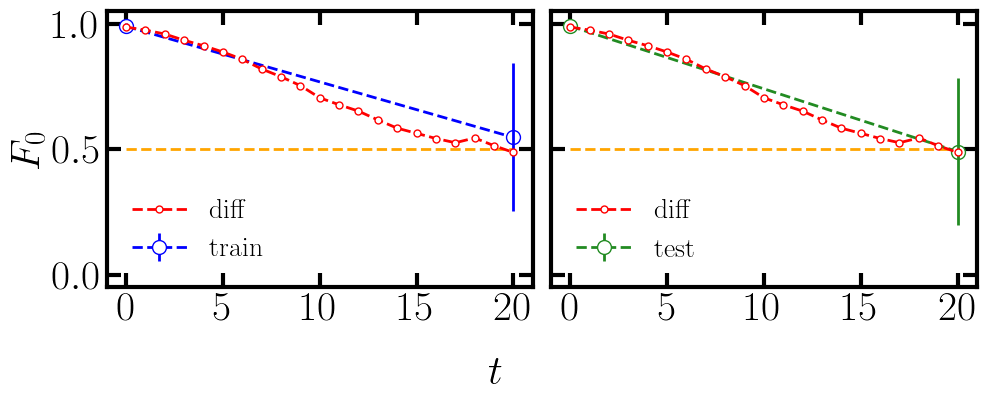

In [12]:
# plot the performance of training with QDT
n, na = 1, 1
T = 20
L = 80
Ndata = 100
method = 'nat'
states_diff = np.load('data/QDDPM/cluster0/n1/cluster0Diff_n1T20_N1000.npy')
states_train = np.load('data/QDT/cluster0/n1/QDTcluster0traingen_n1na1T20L80_nat.npy')
states_test = np.load('data/QDT/cluster0/n1/QDTcluster0testgen_n1na1T20L80_nat.npy')

F0_train = np.abs(states_train[:,:,0])**2
F0_test = np.abs(states_test[:,:,0])**2
F0_diff = np.abs(states_diff[:,:,0])**2

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].errorbar([0, T], np.mean(F0_train, axis=1), yerr=np.std(F0_train, axis=1), fmt='o--',
    lw=2, mfc='white', barsabove=True, markersize=10, c='b', zorder=5, label=r'$\rm train$')
axs[1].errorbar([0, T], np.mean(F0_test,axis=1), yerr=np.std(F0_test, axis=1), fmt='o--',
    lw=2, mfc='white', barsabove=True, markersize=10, c='forestgreen', zorder=5, label=r'$\rm test$')
for i in range(2):
    axs[i].plot(np.arange(T+1), np.mean(F0_diff, axis=1), 'o--', mfc='white',
        lw=2, markersize=5, c='r', zorder=5, label=r'$\rm diff$')
    axs[i].plot(np.arange(T+1), 0.5*np.ones(T+1), '--', lw=2, c='orange')
axs[0].set_ylabel(r'$F_0$', fontsize=30)
for i in range(2):
    axs[i].legend(fontsize=20, framealpha=0)
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_xticks(np.arange(0, T+1,5))
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
fig.supxlabel(r'$t$', fontsize=30)
plt.tight_layout()
plt.savefig('figures/QDTcluster0Fid_n%dna%dT%dL%d.pdf'%(n, na, T, L), bbox_inches='tight')
plt.show()
plt.close()

## 2-qubit

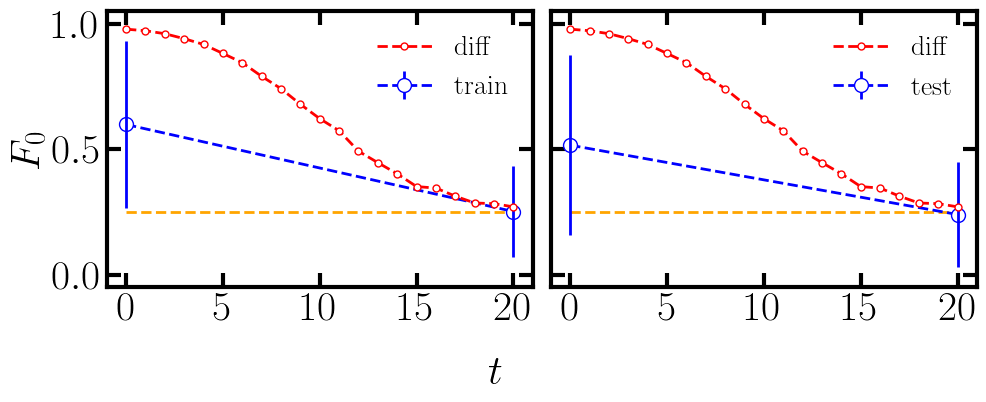

In [13]:
# plot the performance of training with QDT
n, na = 2, 1
T = 20
L = 120
Ndata = 100
method = 'nat'
states_diff = np.load('data/QDDPM/cluster0/n2/cluster0Diff_n2T20_N1000.npy')
states_train = np.load('data/QDT/cluster0/n2/QDTcluster0traingen_n2na1T20L120_nat.npy')
states_test = np.load('data/QDT/cluster0/n2/QDTcluster0testgen_n2na1T20L120_nat.npy')

F0_train = np.abs(states_train[:,:,0])**2
F0_test = np.abs(states_test[:,:,0])**2
F0_diff = np.abs(states_diff[:,:,0])**2

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].errorbar([0, T], np.mean(F0_train, axis=1), yerr=np.std(F0_train, axis=1), fmt='o--',
    lw=2, mfc='white', barsabove=True, markersize=10, c='b', zorder=5, label=r'$\rm train$')
axs[1].errorbar([0, T], np.mean(F0_test,axis=1), yerr=np.std(F0_test, axis=1), fmt='o--',
    lw=2, mfc='white', barsabove=True, markersize=10, c='b', zorder=5, label=r'$\rm test$')
for i in range(2):
    axs[i].plot(np.arange(T+1), np.mean(F0_diff, axis=1), 'o--', mfc='white',
        lw=2, markersize=5, c='r', zorder=5, label=r'$\rm diff$')
    axs[i].plot(np.arange(T+1), 0.25*np.ones(T+1), '--', lw=2, c='orange')
axs[0].set_ylabel(r'$F_0$', fontsize=30)
for i in range(2):
    axs[i].legend(fontsize=20, framealpha=0)
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_xticks(np.arange(0, T+1,5))
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
fig.supxlabel(r'$t$', fontsize=30)
plt.tight_layout()
plt.savefig('figures/QDTcluster0Fid_n%dna%dT%dL%d.pdf'%(n, na, T, L), bbox_inches='tight')
plt.show()
plt.close()